<a href="https://colab.research.google.com/github/quantwav/Lab4-dsff/blob/main/0327_2338.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook settings**



In [126]:
%matplotlib inline
# Use %matplotlib ipympl or %matplotlib widget if you want interactive matplotlib plots
#%matplotlib widget

# Shuts off Jedi to speed up tab completions
# the command %config Completer.use_jedi = False is used in IPython or Jupyter environments to disable the use of the Jedi library for autocompletion, which can sometimes lead to faster completion suggestions.
%config Completer.use_jedi = False

# reloads modules automatically before entering the execution of code typed at the IPython prompt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import multiprocessing
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import scipy.stats as ss
import seaborn as sns
## Import various ML classes from Scikit-learn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm
import string
from time import time

In [128]:
#mport ast refers to importing the ast module, which is a part of Python's standard library. The ast module provides facilities for processing, analyzing, and modifying Abstract Syntax Trees (ASTs).
import ast
import datetime
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import plotly.express as px
import seaborn as sns
import scipy.stats as ss
#The primary use of the tqdm function is to wrap around any iterable, like a list or a loop, to display a smart progress meter.
#For example, if you have a for loop that iterates over a large dataset, you can wrap tqdm around the iterable, and it will display a progress bar that updates with each iteration.
from tqdm import tqdm

!pip install itables
# To display dataframes as interactive tables in the notebook:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

import os

In [129]:
import ast
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import scipy.stats as ss

In [130]:
# https://drive.google.com/file/d/1_YKlTeSfB2L67Db3PV9-kQX181njABvj/view?usp=drive_link

if not os.path.exists("20-diamonds.pq"):
    !gdown --id 1_YKlTeSfB2L67Db3PV9-kQX181njABvj

# **1.Read, verify and clean**




In [131]:
np.seterr(divide='ignore')
pd.options.display.max_colwidth = 150

TOL = 1.0e-12
SEED = 24

In [132]:
df = pd.read_parquet('20-diamonds.pq')
df


dshape        cut color clarity deliv_date     price  carat
0       Emerald  Very Good     J     SI2        NaT     112.0   0.30
1       Emerald       Good     K     SI1        NaT     212.0   0.30
2       Emerald  Very Good     J     SI1        NaT     215.0   0.30
3       Emerald  Very Good     I     SI2        NaT     215.0   0.30
4       Emerald  Very Good     K     VS2        NaT     215.0   0.30
...         ...        ...   ...     ...        ...       ...    ...
131109     Oval  Very Good     E      FL 2021-08-17  548774.0   8.28
131110  Emerald  Very Good     D      FL 2021-08-03  562401.0   7.00
131111    Round      Ideal     D    VVS2 2021-08-02  577753.0   8.10
131112  Emerald  Very Good     D      FL 2021-08-02  717968.0   8.16
131113    Round      Ideal     D      FL 2021-08-17  821831.0   7.81

[131114 rows x 7 columns]

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131114 entries, 0 to 131113
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   dshape      131114 non-null  object        
 1   cut         131114 non-null  object        
 2   color       131114 non-null  object        
 3   clarity     131114 non-null  object        
 4   deliv_date  129479 non-null  datetime64[ns]
 5   price       131114 non-null  float64       
 6   carat       131114 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 7.0+ MB


**Rename Columns**: Columns `'dshape'` and `'color'` are renamed to `'c_shape'` and `'c_color'`, respectively.

**Change Data Types**: The data type of the newly named `'c_shape'` and `'c_color'` columns are converted to the category data type. This is done to potentially reduce memory usage and to signify that these columns contain categorical data.


In [134]:
df = (
    df
    .rename(columns={'dshape':'c_shape'})
    .assign(c_shape=lambda x: x.c_shape.astype('category')
           )
    .drop(columns= ['deliv_date'])
)
df.info()
df.c_shape.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131114 entries, 0 to 131113
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   c_shape  131114 non-null  category
 1   cut      131114 non-null  object  
 2   color    131114 non-null  object  
 3   clarity  131114 non-null  object  
 4   price    131114 non-null  float64 
 5   carat    131114 non-null  float64 
dtypes: category(1), float64(2), object(3)
memory usage: 5.1+ MB


Round       82450
Oval        11526
Emerald     10404
Princess     8017
Cushion      7218
Pear         5426
Radiant      1913
Heart        1611
Marquise     1453
Asscher      1096
Name: c_shape, dtype: int64

In [140]:
df.color.value_counts()

D    21825
E    20834
F    20549
G    19591
H    16025
I    14473
J    11695
K     6122
Name: color, dtype: int64

This step creates a new column `color_encoded` in the DataFrame `df` by mapping the `color` column's values to a numeric scale defined in the `color_order` dictionary. Each diamond clarity grade is assigned a unique numeric value indicating its quality, with 'D' being the highest quality at 8, down to 'K' as the lowest at 1. After encoding, the original `color` column is removed from the DataFrame.


In [141]:
color_order = {
    'D': 8,   # Flawless
    'E': 7,   # Internally Flawless
    'F': 6,  # Very, Very Slightly Included (level 1)
    'G': 5,  # Very, Very Slightly Included (level 2)
    'H': 4,   # Very Slightly Included (level 1)
    'I': 3,   # Very Slightly Included (level 2)
    'J': 2,   # Slightly Included (level 1)
    'K': 1,   # Slightly Included (level 2)
}

df['color_encoded'] = df['color'].map(color_order)

df = df.drop(columns = ['color'])

df

c_shape        cut clarity     price  carat  color_encoded
0       Emerald  Very Good     SI2     112.0   0.30              2
1       Emerald       Good     SI1     212.0   0.30              1
2       Emerald  Very Good     SI1     215.0   0.30              2
3       Emerald  Very Good     SI2     215.0   0.30              3
4       Emerald  Very Good     VS2     215.0   0.30              1
...         ...        ...     ...       ...    ...            ...
131109     Oval  Very Good      FL  548774.0   8.28              7
131110  Emerald  Very Good      FL  562401.0   7.00              8
131111    Round      Ideal    VVS2  577753.0   8.10              8
131112  Emerald  Very Good      FL  717968.0   8.16              8
131113    Round      Ideal      FL  821831.0   7.81              8

[131114 rows x 6 columns]

This step creates a new column `clarity_encoded` in the DataFrame `df` by mapping the `clarity` column's values to a numeric scale defined in the `clarity_order` dictionary. Each diamond clarity grade is assigned a unique numeric value indicating its quality, with 'FL' (Flawless) being the highest quality at 11, down to 'I3' (Included level 3) as the lowest at 1. After encoding, the original `clarity` column is removed from the DataFrame.


In [142]:
clarity_order = {
    'FL': 11,   # Flawless
    'IF': 10,   # Internally Flawless
    'VVS1': 9,  # Very, Very Slightly Included (level 1)
    'VVS2': 8,  # Very, Very Slightly Included (level 2)
    'VS1': 7,   # Very Slightly Included (level 1)
    'VS2': 6,   # Very Slightly Included (level 2)
    'SI1': 5,   # Slightly Included (level 1)
    'SI2': 4,   # Slightly Included (level 2)
    'I1': 3,    # Included (level 1)
    'I2': 2,    # Included (level 2)
    'I3': 1     # Included (level 3)
}

df['clarity_encoded'] = df['clarity'].map(clarity_order)

df = df.drop(columns = ['clarity'])

df

c_shape        cut     price  carat  color_encoded  clarity_encoded
0       Emerald  Very Good     112.0   0.30              2                4
1       Emerald       Good     212.0   0.30              1                5
2       Emerald  Very Good     215.0   0.30              2                5
3       Emerald  Very Good     215.0   0.30              3                4
4       Emerald  Very Good     215.0   0.30              1                6
...         ...        ...       ...    ...            ...              ...
131109     Oval  Very Good  548774.0   8.28              7               11
131110  Emerald  Very Good  562401.0   7.00              8               11
131111    Round      Ideal  577753.0   8.10              8                8
131112  Emerald  Very Good  717968.0   8.16              8               11
131113    Round      Ideal  821831.0   7.81              8               11

[131114 rows x 6 columns]

In [61]:
df.cut.value_counts()

Ideal          62806
Very Good      55538
Good           12045
Astor Ideal      725
Name: cut, dtype: int64

Introduce a new column `cut_encoded` to the DataFrame `df` by mapping the values from the `cut` column to a numeric scale specified in the `cut_order` dictionary. Each cut quality, from 'Astor Ideal' as the highest quality (4) down to 'Good' as the lowest (1), is assigned a specific numeric value. Following the mapping, the original `cut` column is removed from the DataFrame.


In [143]:
cut_order = {
    'Astor Ideal': 4,
    'Ideal': 3,
    'Very Good': 2,
    'Good': 1
}
#

df['cut_encoded'] = df['cut'].map(cut_order)

df = df.drop( columns= 'cut')

df

c_shape     price  carat  color_encoded  clarity_encoded  cut_encoded
0       Emerald     112.0   0.30              2                4            2
1       Emerald     212.0   0.30              1                5            1
2       Emerald     215.0   0.30              2                5            2
3       Emerald     215.0   0.30              3                4            2
4       Emerald     215.0   0.30              1                6            2
...         ...       ...    ...            ...              ...          ...
131109     Oval  548774.0   8.28              7               11            2
131110  Emerald  562401.0   7.00              8               11            2
131111    Round  577753.0   8.10              8                8            3
131112  Emerald  717968.0   8.16              8               11            2
131113    Round  821831.0   7.81              8               11            3

[131114 rows x 6 columns]

In [63]:
df.color.value_counts()

D    21825
E    20834
F    20549
G    19591
H    16025
I    14473
J    11695
K     6122
Name: color, dtype: int64

Then process each column in the DataFrame `df` that starts with 'c_'. For each of these columns, it generates dummy variables with `pd.get_dummies`, adding a prefix 'i_' to each dummy column name and dropping the first dummy variable to prevent multicollinearity. The newly created dummy variables are then concatenated to the original DataFrame `df` along the axis=1, expanding `df` with these new features.


In [144]:
clist = [v for v in df.columns if v.startswith('c_')]
for c in clist:
    d = pd.get_dummies(df[c],'i_'+c,drop_first=True)
    df = pd.concat((df,d),axis=1)

df

c_shape     price  carat  color_encoded  clarity_encoded  cut_encoded  \
0       Emerald     112.0   0.30              2                4            2   
1       Emerald     212.0   0.30              1                5            1   
2       Emerald     215.0   0.30              2                5            2   
3       Emerald     215.0   0.30              3                4            2   
4       Emerald     215.0   0.30              1                6            2   
...         ...       ...    ...            ...              ...          ...   
131109     Oval  548774.0   8.28              7               11            2   
131110  Emerald  562401.0   7.00              8               11            2   
131111    Round  577753.0   8.10              8                8            3   
131112  Emerald  717968.0   8.16              8               11            2   
131113    Round  821831.0   7.81              8               11            3   

        i_c_shape_Cushion  i_c_shape_Emerald  i_c_shape_Heart  \
0                       0                  1                0   
1                       0                  1                0   
2                       0                  1                0   
3                       0                  1                0   
4                       0                  1                0   
...                   ...                ...              ...   
131109                  0                  0                0   
131110                  0                  1                0   
131111                  0                  0                0   
131112                  0                  1                0   
131113                  0                  0                0   

        i_c_shape_Marquise  i_c_shape_Oval  i_c_shape_Pear  \
0                        0               0               0   
1                        0               0               0   
2                        0               0               0   
3                        0               0               0   
4                        0               0               0   
...                    ...             ...             ...   
131109                   0               1               0   
131110                   0               0               0   
131111                   0               0               0   
131112                   0               0               0   
131113                   0               0               0   

        i_c_shape_Princess  i_c_shape_Radiant  i_c_shape_Round  
0                        0                  0                0  
1                        0                  0                0  
2                        0                  0                0  
3                        0                  0                0  
4                        0                  0                0  
...                    ...                ...              ...  
131109                   0                  0                0  
131110                   0                  0                0  
131111                   0                  0                1  
131112                   0                  0                0  
131113                   0                  0                1  

[131114 rows x 15 columns]

The values should all be nonnegative. Price and carat should be strictly positive unless someone is giving away their rental.

In [145]:
vlist = ['price','carat']
for v in vlist:
    if v != 'price':
        df[v] = np.where(df[v]<0,np.NaN,df[v])
    else:
        df[v] = np.where(df[v]<=0,np.NaN,df[v])

Take logs of the variables, carefully.

In [146]:
for v in vlist:
    if v in ['price']:
        df['l_'+v] = np.log(df[v])
    else:
        df['l_'+v] = np.log(1+df[v])

df

c_shape     price  carat  color_encoded  clarity_encoded  cut_encoded  \
0       Emerald     112.0   0.30              2                4            2   
1       Emerald     212.0   0.30              1                5            1   
2       Emerald     215.0   0.30              2                5            2   
3       Emerald     215.0   0.30              3                4            2   
4       Emerald     215.0   0.30              1                6            2   
...         ...       ...    ...            ...              ...          ...   
131109     Oval  548774.0   8.28              7               11            2   
131110  Emerald  562401.0   7.00              8               11            2   
131111    Round  577753.0   8.10              8                8            3   
131112  Emerald  717968.0   8.16              8               11            2   
131113    Round  821831.0   7.81              8               11            3   

        i_c_shape_Cushion  i_c_shape_Emerald  i_c_shape_Heart  \
0                       0                  1                0   
1                       0                  1                0   
2                       0                  1                0   
3                       0                  1                0   
4                       0                  1                0   
...                   ...                ...              ...   
131109                  0                  0                0   
131110                  0                  1                0   
131111                  0                  0                0   
131112                  0                  1                0   
131113                  0                  0                0   

        i_c_shape_Marquise  i_c_shape_Oval  i_c_shape_Pear  \
0                        0               0               0   
1                        0               0               0   
2                        0               0               0   
3                        0               0               0   
4                        0               0               0   
...                    ...             ...             ...   
131109                   0               1               0   
131110                   0               0               0   
131111                   0               0               0   
131112                   0               0               0   
131113                   0               0               0   

        i_c_shape_Princess  i_c_shape_Radiant  i_c_shape_Round    l_price  \
0                        0                  0                0   4.718499   
1                        0                  0                0   5.356586   
2                        0                  0                0   5.370638   
3                        0                  0                0   5.370638   
4                        0                  0                0   5.370638   
...                    ...                ...              ...        ...   
131109                   0                  0                0  13.215442   
131110                   0                  0                0  13.239970   
131111                   0                  0                1  13.266902   
131112                   0                  0                0  13.484180   
131113                   0                  0                1  13.619290   

         l_carat  
0       0.262364  
1       0.262364  
2       0.262364  
3       0.262364  
4       0.262364  
...          ...  
131109  2.227862  
131110  2.079442  
131111  2.208274  
131112  2.214846  
131113  2.175887  

[131114 rows x 17 columns]

In [ ]:
df['const'] = 1

## **Final Check**

In [ ]:
assert df.isna().sum().sum() == 0  # no missing values

numeric = df.dtypes.loc[lambda x: (x != 'object') & (x != 'category') & (x.index != 'const')].index
assert (df[numeric].std(axis=0) > TOL).all()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131114 entries, 0 to 131113
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   c_shape             131114 non-null  category
 1   c_color             131114 non-null  category
 2   price               131114 non-null  float64 
 3   carat               131114 non-null  float64 
 4   clarity_encoded     131114 non-null  int64   
 5   cut_encoded         131114 non-null  int64   
 6   i_c_shape_Cushion   131114 non-null  uint8   
 7   i_c_shape_Emerald   131114 non-null  uint8   
 8   i_c_shape_Heart     131114 non-null  uint8   
 9   i_c_shape_Marquise  131114 non-null  uint8   
 10  i_c_shape_Oval      131114 non-null  uint8   
 11  i_c_shape_Pear      131114 non-null  uint8   
 12  i_c_shape_Princess  131114 non-null  uint8   
 13  i_c_shape_Radiant   131114 non-null  uint8   
 14  i_c_shape_Round     131114 non-null  uint8   
 15  i_c_color_E      

In [148]:
df

c_shape     price  carat  color_encoded  clarity_encoded  cut_encoded  \
0       Emerald     112.0   0.30              2                4            2   
1       Emerald     212.0   0.30              1                5            1   
2       Emerald     215.0   0.30              2                5            2   
3       Emerald     215.0   0.30              3                4            2   
4       Emerald     215.0   0.30              1                6            2   
...         ...       ...    ...            ...              ...          ...   
131109     Oval  548774.0   8.28              7               11            2   
131110  Emerald  562401.0   7.00              8               11            2   
131111    Round  577753.0   8.10              8                8            3   
131112  Emerald  717968.0   8.16              8               11            2   
131113    Round  821831.0   7.81              8               11            3   

        i_c_shape_Cushion  i_c_shape_Emerald  i_c_shape_Heart  \
0                       0                  1                0   
1                       0                  1                0   
2                       0                  1                0   
3                       0                  1                0   
4                       0                  1                0   
...                   ...                ...              ...   
131109                  0                  0                0   
131110                  0                  1                0   
131111                  0                  0                0   
131112                  0                  1                0   
131113                  0                  0                0   

        i_c_shape_Marquise  i_c_shape_Oval  i_c_shape_Pear  \
0                        0               0               0   
1                        0               0               0   
2                        0               0               0   
3                        0               0               0   
4                        0               0               0   
...                    ...             ...             ...   
131109                   0               1               0   
131110                   0               0               0   
131111                   0               0               0   
131112                   0               0               0   
131113                   0               0               0   

        i_c_shape_Princess  i_c_shape_Radiant  i_c_shape_Round    l_price  \
0                        0                  0                0   4.718499   
1                        0                  0                0   5.356586   
2                        0                  0                0   5.370638   
3                        0                  0                0   5.370638   
4                        0                  0                0   5.370638   
...                    ...                ...              ...        ...   
131109                   0                  0                0  13.215442   
131110                   0                  0                0  13.239970   
131111                   0                  0                1  13.266902   
131112                   0                  0                0  13.484180   
131113                   0                  0                1  13.619290   

         l_carat  
0       0.262364  
1       0.262364  
2       0.262364  
3       0.262364  
4       0.262364  
...          ...  
131109  2.227862  
131110  2.079442  
131111  2.208274  
131112  2.214846  
131113  2.175887  

[131114 rows x 17 columns]

# **2.Train-test split**

In [147]:
train_size = 0.75
df_train = df.sample(frac=train_size,random_state=SEED)
train_idx = df_train.index
df_test = df.loc[~(df.index.isin(train_idx))]

assert set(df_test.index) & set(train_idx) == set()
assert set(df_test.index) | set(train_idx) == set(df.index)
assert (df_test.columns == df_train.columns).all()

## **Variable lists by data type**

In [149]:
cat_list = [c for c in df.columns if c.startswith('c_') ]
num_list = [c for c in df.columns if (c not in cat_list) & ~(c.startswith('i_')) & (c != 'const')]

num_list

df[num_list].dtypes

#Check Data Types: Ensure that the columns in df, df_train, and df_test referred to by num_list contain numeric data.
df[num_list].dtypes
df_train[num_list].dtypes
df_test[num_list].dtypes

price              float64
carat              float64
color_encoded        int64
clarity_encoded      int64
cut_encoded          int64
l_price            float64
l_carat            float64
dtype: object

## **Sample mean equality**

In [ ]:
mu=df[num_list].mean()
se=df[num_list].std()/np.sqrt(len(df))

mu_train=df_train[num_list].mean()
se_train=df_train[num_list].std()/np.sqrt(len(df_train))

mu_test=df_test[num_list].mean()
se_test=df_test[num_list].std()/np.sqrt(len(df_test))

t_train=(mu - mu_train) / np.sqrt(se**2 + se_train**2)
t_test=(mu - mu_test) / np.sqrt(se**2 + se_test**2)

x = pd.concat((mu,mu_train,mu_test,t_train,t_test),
          axis=1,
          keys=['avg-full','avg-train','avg-test','t_train','t_test']
         )

# test for significance
assert (x.t_train < 1.65).all()
assert (x.t_test < 1.65).all()

x.style.format("{:.2f}")

,avg-full,avg-train,avg-test,t_train,t_test
price,6414.02,6419.26,6398.32,-0.08,0.16
carat,0.85,0.85,0.86,0.37,-0.75
clarity_encoded,6.48,6.48,6.47,-0.31,0.64
cut_encoded,2.40,2.40,2.39,-0.49,1.01
l_price,7.79,7.79,7.80,0.43,-0.88
l_carat,0.57,0.57,0.57,0.54,-1.10


## **Categorical variables**

In [ ]:
c = 'c_color'

eperc=df[c].value_counts(normalize=True)

# train test

etrain=(eperc*df_train.shape[0]).sort_index()

atrain=df_train[c].value_counts().sort_index()

chi2train=ss.chisquare(f_obs=atrain,f_exp=etrain)

# test test

etest=(eperc*df_test.shape[0]).sort_index()

atest=df_test[c].value_counts().sort_index()

chi2test=ss.chisquare(f_obs=atest,f_exp=etest)

#    A higher p-value suggests no significant difference.
print(f"Train Chi2 = {chi2train.pvalue:.2%}\nTest Chi2 = {chi2test.pvalue:.2%}")

Train Chi2 = 98.56%
Test Chi2 = 75.66%


## **Visualization (for small number categories)**

Chi2 p-values in parentheses
   index   c_color          key
0      D  0.166458         Full
1      E  0.158900         Full
2      F  0.156726         Full
3      G  0.149420         Full
4      H  0.122222         Full
5      I  0.110385         Full
6      J  0.089197         Full
7      K  0.046692         Full
8      D  0.165931  Train (99%)
9      E  0.159077  Train (99%)
10     F  0.157643  Train (99%)
11     G  0.149599  Train (99%)
12     H  0.122285  Train (99%)
13     I  0.110346  Train (99%)
14     J  0.088960  Train (99%)
15     K  0.046158  Train (99%)
16     D  0.168040   Test (76%)
17     E  0.158368   Test (76%)
18     F  0.153975   Test (76%)
19     G  0.148880   Test (76%)
20     H  0.122033   Test (76%)
21     I  0.110501   Test (76%)
22     J  0.089908   Test (76%)
23     K  0.048295   Test (76%)
['c_shape', 'c_color']


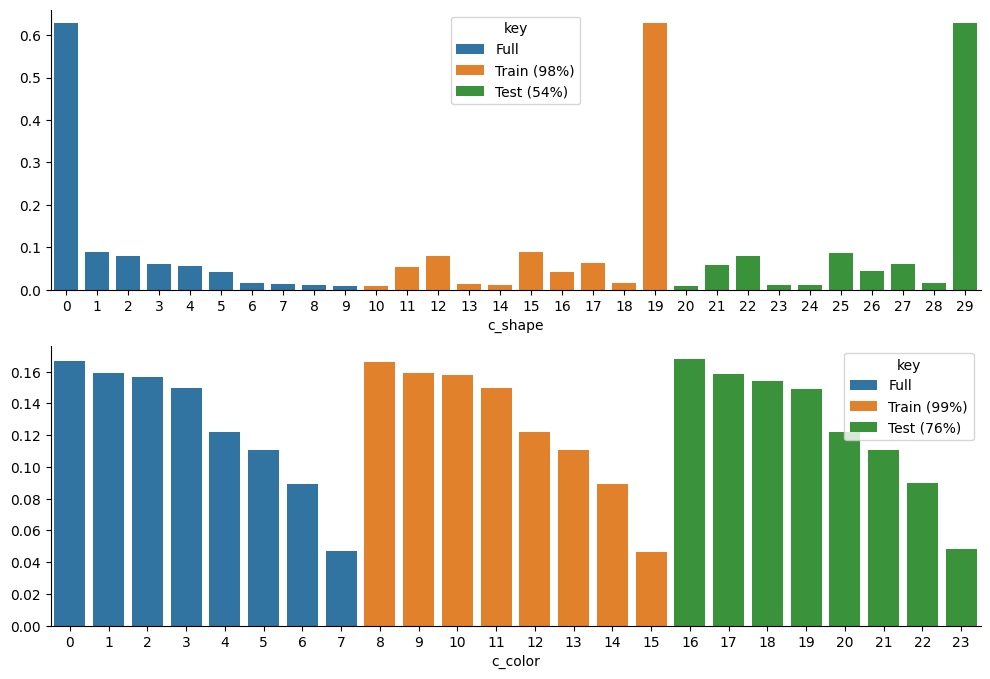

In [ ]:

fig,axes=plt.subplots(len(cat_list),1,figsize=(12,len(cat_list)*4))
axes=np.ravel(axes)


for c,ax in zip(cat_list,axes):
    eperc=df[c].value_counts(normalize=True)

    # train test
    etrain=(eperc*df_train.shape[0]).sort_index()
    atrain=df_train[c].value_counts().sort_index()
    chi2train=ss.chisquare(f_obs=atrain,f_exp=etrain)

    # test test
    etest=(eperc*df_test.shape[0]).sort_index()
    atest=df_test[c].value_counts().sort_index()
    chi2test=ss.chisquare(f_obs=atest,f_exp=etest)

    eperc=eperc.to_frame().assign(key='Full')
    trainperc=(atrain/atrain.sum()).to_frame().assign(key=f'Train ({chi2train.pvalue:.0%})')
    testperc=(atest/atest.sum()).to_frame().assign(key=f'Test ({chi2test.pvalue:.0%})')
    z = pd.concat((eperc,trainperc,testperc),axis=0).reset_index()

    #print(z.index)
    sns.barplot(x=z.index, y=c, hue='key', data=z,ax=ax)
    ax.set_xlabel(c)
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

print("Chi2 p-values in parentheses")
print(z)
print(cat_list)

In [ ]:
df_train.reset_index(drop=True).to_parquet('Diamond-wrangling-split-train.pq')
df_test.reset_index(drop=True).to_parquet('Diamond-wrangling-split-test.pq')

kvars = [
    'c_shape', 'c_color', 'price', 'carat', 'clarity_encoded', 'cut_encoded'
]
df[kvars].reset_index(drop=True).to_parquet('Diamond-wrangling-split.pq')

# **3.EDA**

## **Summary stats**

In [ ]:
vlist = [c for c in df.columns]
df[vlist].describe().T.style.format("{:,.2f}")

,count,mean,std,min,25%,50%,75%,max
price,"131,114.00","6,414.02","15,768.83",112.00,727.00,"2,307.00","6,055.00","821,831.00"
carat,"131,114.00",0.85,0.71,0.23,0.37,0.70,1.01,8.50
clarity_encoded,"131,114.00",6.48,1.77,4.00,5.00,6.00,8.00,11.00
cut_encoded,"131,114.00",2.40,0.66,1.00,2.00,2.00,3.00,4.00
i_c_shape_Cushion,"131,114.00",0.06,0.23,0.00,0.00,0.00,0.00,1.00
i_c_shape_Emerald,"131,114.00",0.08,0.27,0.00,0.00,0.00,0.00,1.00
i_c_shape_Heart,"131,114.00",0.01,0.11,0.00,0.00,0.00,0.00,1.00
i_c_shape_Marquise,"131,114.00",0.01,0.10,0.00,0.00,0.00,0.00,1.00
i_c_shape_Oval,"131,114.00",0.09,0.28,0.00,0.00,0.00,0.00,1.00
i_c_shape_Pear,"131,114.00",0.04,0.20,0.00,0.00,0.00,0.00,1.00


Plot the price and logprice distribution.

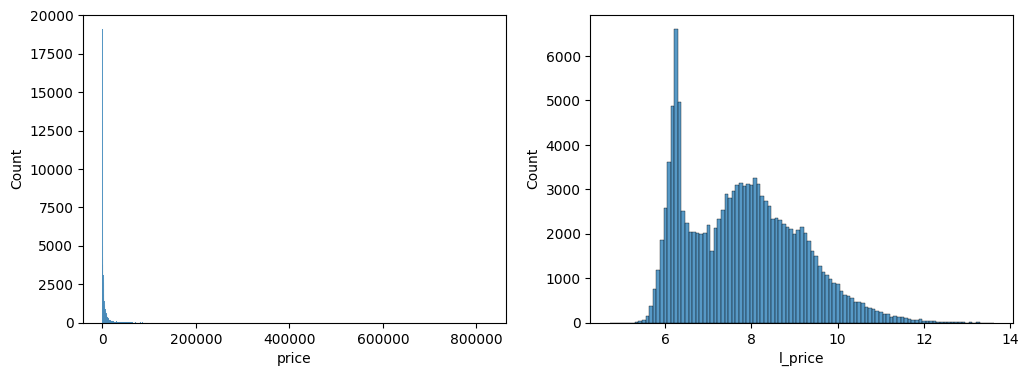

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
sns.histplot(df.price,ax=ax[0])
sns.histplot(df.l_price,ax=ax[1]);

The first histogram shows the distribution of `price` with a significant skew to the right, indicating that most of the data points are concentrated on the lower end of the price scale with fewer high-value outliers.

The second histogram depicts the distribution of `l_price`, which is the logarithmically transformed prices. This transformation typically aims to normalize data and reduce the impact of outliers. The `l_price` distribution appears more symmetrical and bell-shaped, suggesting that the log transformation has helped in making the distribution more normal, which is often a desirable property for various statistical analysis techniques.


## **Utility funciton**

In [174]:
def create_barplot(data,col,palette='muted'):
    x = data[col].value_counts(normalize=True).sort_index()
    fig,ax=plt.subplots(1,1,figsize=(12,4))
    ax=sns.barplot(x=x.index,y=x,ax=ax);
    ax.set_xlabel(col)
    ax.set_ylabel("Fraction of observations")


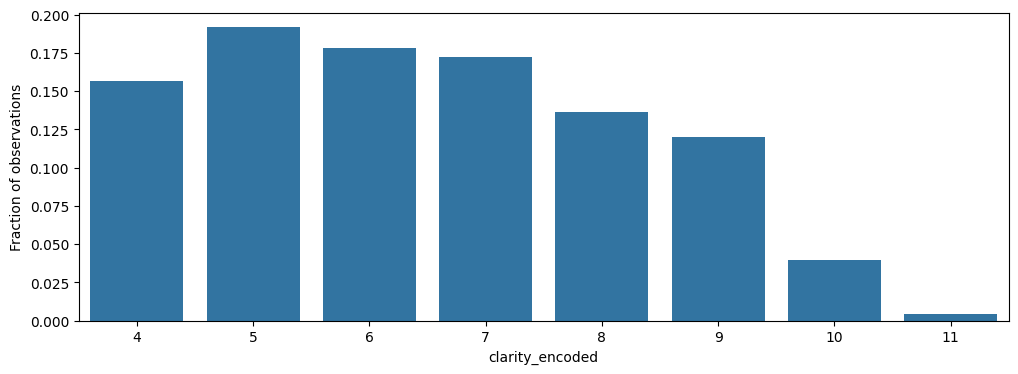

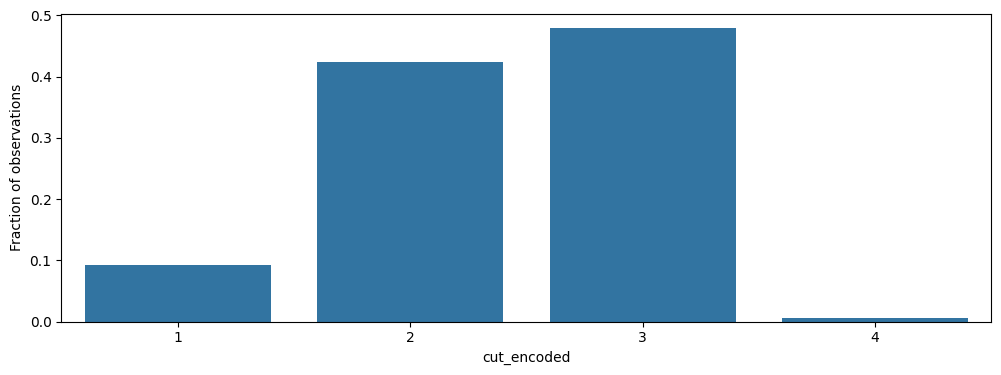

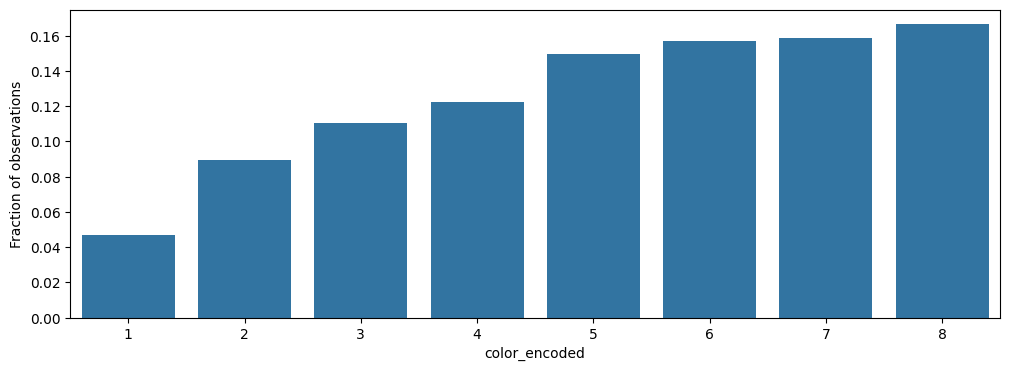

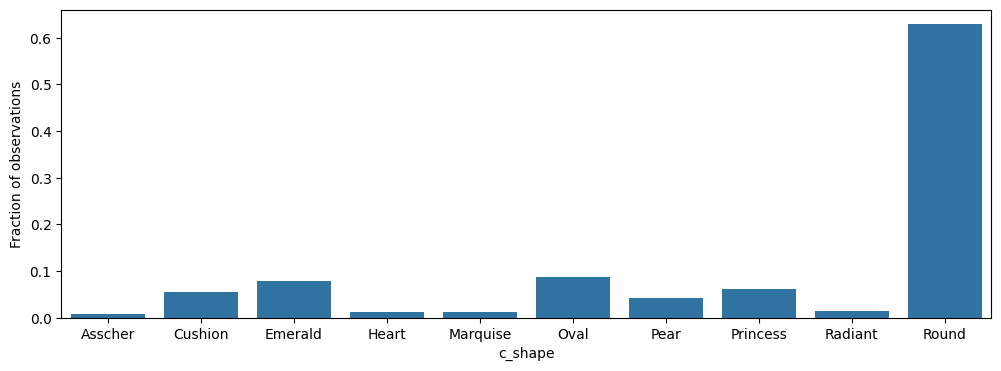

In [175]:
create_barplot(df,'clarity_encoded',palette='pastel' )
create_barplot(df,'cut_encoded',palette='paste2' )
create_barplot(df,'color_encoded')
create_barplot(df,'c_shape')

## **Price relations**

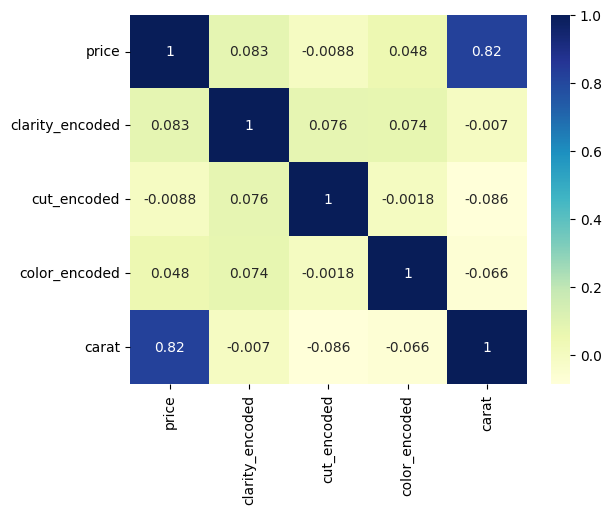

In [176]:
x=df[['price','clarity_encoded','cut_encoded','color_encoded','carat']].corr()
sns.heatmap(x,cmap="YlGnBu",annot=True);

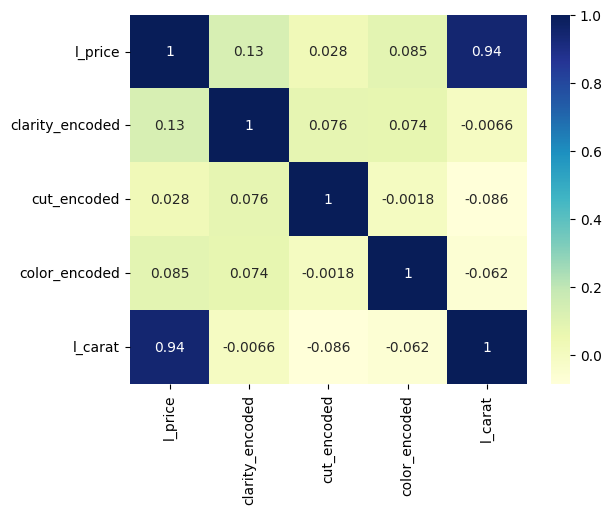

In [177]:
x=df[['l_price','clarity_encoded','cut_encoded','color_encoded','l_carat']].corr()
sns.heatmap(x,cmap="YlGnBu",annot=True);

## **Pairs plot**

## **Linear**


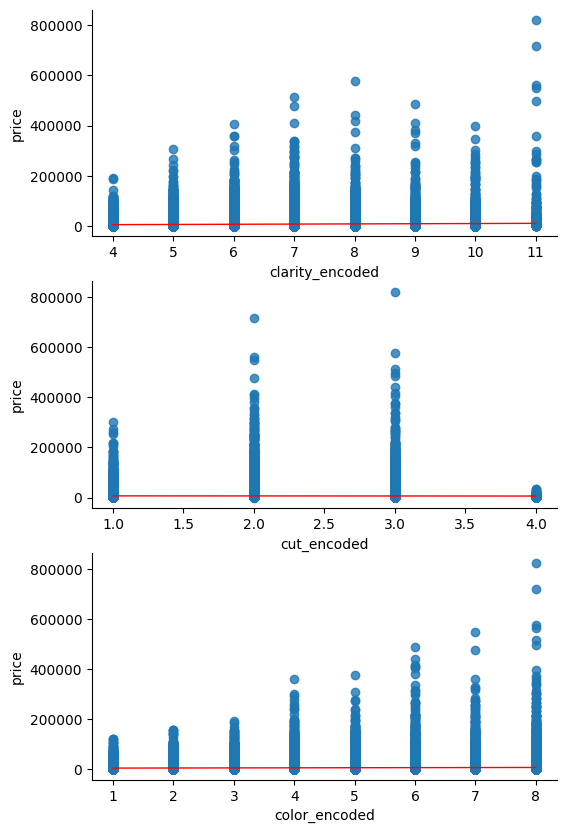

In [197]:
vlist = ['clarity_encoded','cut_encoded','color_encoded','carat']
fig,axes=plt.subplots(3,1,figsize=(6,10))
axes=np.ravel(axes)
for v,ax in zip(vlist,axes):
    sns.regplot(y=df.price,x=df[v],line_kws={'color':'r','linewidth':1},ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

## **Log**

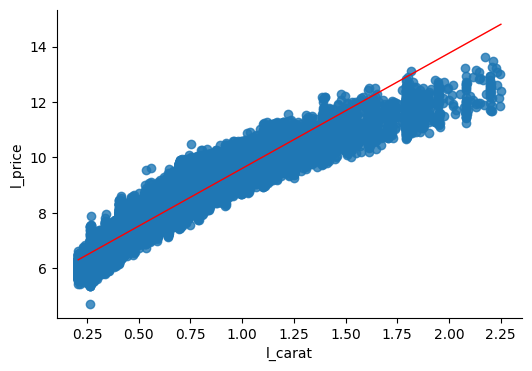

In [180]:
lvlist = ['l_carat']
fig,axes=plt.subplots(figsize=(6,4))
axes=np.ravel(axes)
for v,ax in zip(lvlist,axes):
    sns.regplot(y=df.l_price,x=df[v],line_kws={'color':'r','linewidth':1},ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

## **Polynomial**

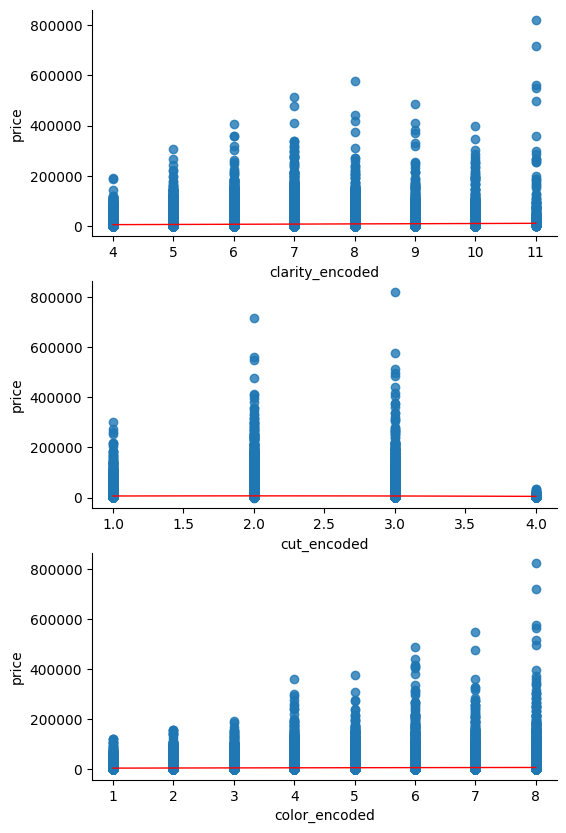

In [181]:
fig,axes=plt.subplots(3,1, figsize=(6,10))
axes=np.ravel(axes)
#order=2 is a key part of this line. It specifies that the regression should be a polynomial regression of order 2, which means a quadratic regression (the form of the regression line will be ax² + bx + c).
for v,ax in zip(vlist,axes):
    sns.regplot(y=df.price,x=df[v],order=2,line_kws={'color':'r','linewidth':1},ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

## **Categorical**

<ipython-input-193-a71248c569c6>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='c_shape', y='l_price', data=df, kind='box' ,palette='Set2',aspect=2.5 );


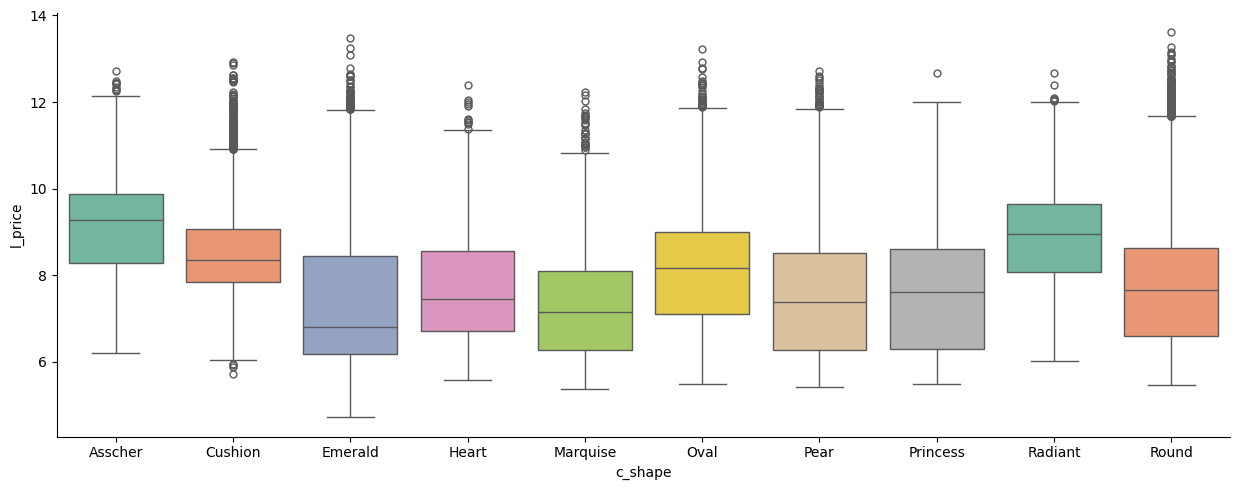

In [193]:
sns.catplot(x='c_shape', y='l_price', data=df, kind='box' ,palette='Set2',aspect=2.5 );

<ipython-input-194-7fa4af33e106>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='color_encoded', y='l_price', data=df, kind='box' ,palette='Set2',aspect=2.5 );


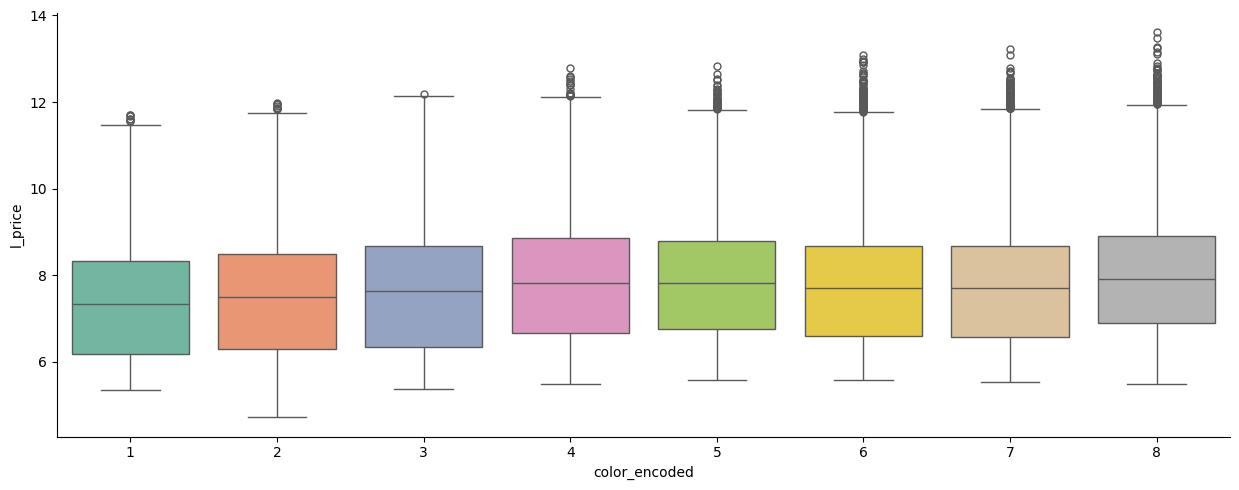

In [194]:
sns.catplot(x='color_encoded', y='l_price', data=df, kind='box' ,palette='Set2',aspect=2.5 );

<ipython-input-195-86249b70fcc6>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='clarity_encoded', y='l_price', data=df, kind='box' ,palette='Set2',aspect=2.5 );


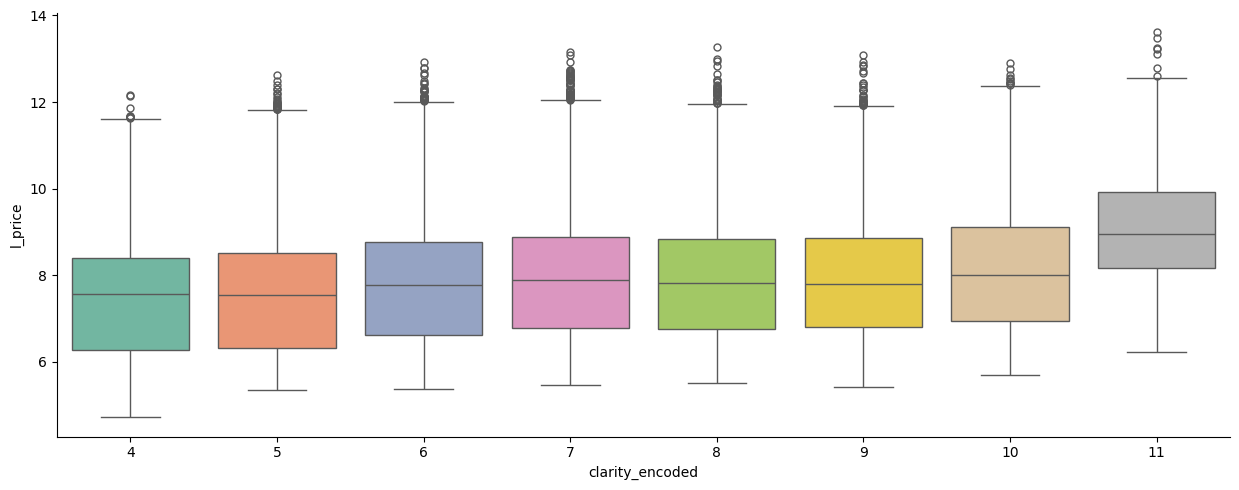

In [195]:
sns.catplot(x='clarity_encoded', y='l_price', data=df, kind='box' ,palette='Set2',aspect=2.5 );

<ipython-input-196-5dc8ba11e856>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='cut_encoded', y='l_price', data=df, kind='box' ,palette='Set2',aspect=2.5 );


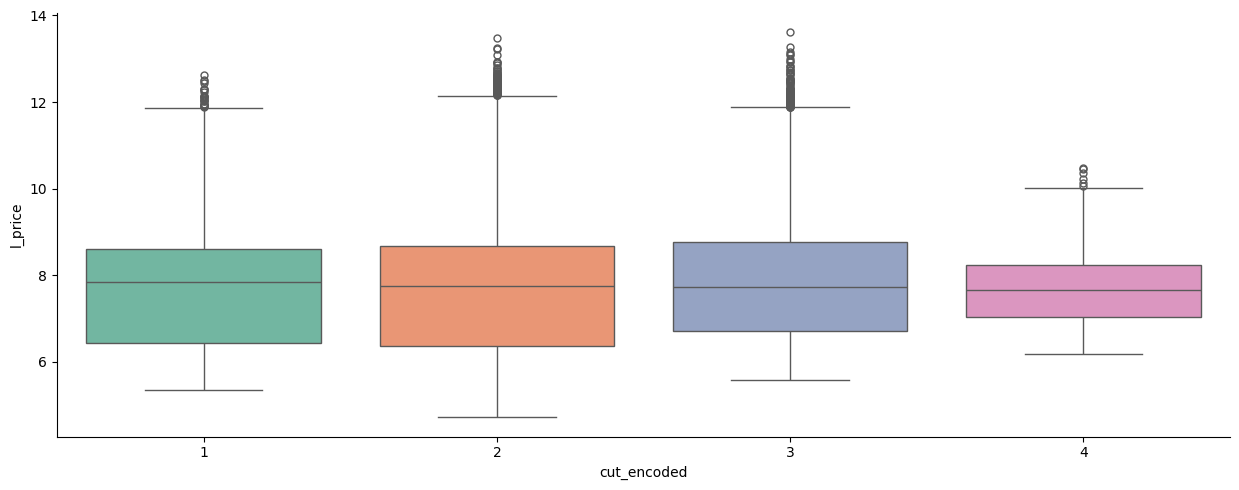

In [196]:
sns.catplot(x='cut_encoded', y='l_price', data=df, kind='box' ,palette='Set2',aspect=2.5 );

# **4.Linear Regression**

In [150]:
#@timer_func: This is a decorator. In Python, a decorator is a function that takes another function and extends its behavior without explicitly modifying it. @timer_func is likely a custom decorator, designed to measure and report the time it takes for the cval function to run.
#def cval(mod, X, y, folds=3, scoring='r2'):: This is the declaration of the function cval. It takes several arguments:
#    mod: The model to be cross-validated.
#    X: The features dataset.
#    y: The target dataset.
#    folds=3: An optional parameter that sets the number of folds for cross-validation. Here, it is set to 3.
#    scoring='r2': Another optional parameter that defines the scoring metric to be used. Here, it is set to R2
# The triple quotes (''' ... '''): These lines are a docstring, providing a brief description of the function.
#cv = cross_val_score(mod, X, y, cv=folds, scoring=scoring, n_jobs=CPUS-1): This line calls the cross_val_score function from Scikit-learn.
#    cross_val_score is a utility to perform cross-validation.
#    n_jobs=CPUS-1 is an argument where CPUS is likely a variable indicating the number of CPU cores available. It tells the function to use one less than the total number of CPUs for parallel processing, which can speed up the computation.



def timer_func(func):
   def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        t = str(datetime.timedelta(seconds=t2-t1))
        print(f'Function {func.__name__!r} executed in {t}')
        return result
   return wrap_func

@timer_func
def cval(mod,X,y,folds=3,scoring='r2'):
    ''' Args: mod, X, y, folds=3, scoring='r2' '''

    cv = cross_val_score(mod,X,y,cv=folds,scoring=scoring,n_jobs=CPUS-1)
    print(f"Fold scores:\n{cv}")
    print(f"Mean score: {cv.mean():.8f}")
    print(f"Default parameters:\n{mod.get_params()}")

    return cv

In [151]:
r = LinearRegression() #This is a call to the constructor of the LinearRegression class.

In [152]:
yvar = 'l_price'
y_train = df_train[yvar]

# exclude zip to make things run more quickly
xvars =  (
    ['clarity_encoded','cut_encoded','color_encoded','l_carat']
    + [c for c in df_train.columns if c.startswith('i_c_shape')|c.startswith('i_c_color') ]
)
X_train = df_train[xvars]

folds = 3
print(X_train)

        clarity_encoded  cut_encoded  color_encoded   l_carat  \
121757                5            3              4  1.071584   
53521                 8            3              2  0.470004   
45450                 7            3              5  0.371564   
20269                 5            2              7  0.285179   
51153                 4            3              5  0.405465   
...                 ...          ...            ...       ...   
90314                 9            2              2  0.693147   
87117                 7            3              6  0.593327   
74173                 4            2              6  0.693147   
15489                 4            3              6  0.262364   
11132                 5            3              3  0.270027   

        i_c_shape_Cushion  i_c_shape_Emerald  i_c_shape_Heart  \
121757                  0                  0                0   
53521                   0                  0                0   
45450                   

In [153]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
CPUS = multiprocessing.cpu_count()
r_cv = cross_val_score(r, #r: linear regression model instantiated above
                     X_train,
                     y_train,
                     cv=folds,
                     scoring='r2',
                     n_jobs=CPUS-1
                    )
print(f"Default model parameters:\n{r.get_params()}")
print(f"Fold scores:\n{r_cv}")
print(f"Mean score: {r_cv.mean():.8f}")

Default model parameters:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Fold scores:
[0.94408668 0.94344275 0.94331514]
Mean score: 0.94361486


# **5.Different models**
## **Lasso Regression**

In [154]:
df_train.head()

c_shape    price  carat  color_encoded  clarity_encoded  cut_encoded  \
121757     Round  18236.0   1.92              4                5            3   
53521      Round   1645.0   0.60              2                8            3   
45450      Round   1240.0   0.45              5                7            3   
20269   Marquise    533.0   0.33              7                5            2   
51153      Round   1529.0   0.50              5                4            3   

        i_c_shape_Cushion  i_c_shape_Emerald  i_c_shape_Heart  \
121757                  0                  0                0   
53521                   0                  0                0   
45450                   0                  0                0   
20269                   0                  0                0   
51153                   0                  0                0   

        i_c_shape_Marquise  i_c_shape_Oval  i_c_shape_Pear  \
121757                   0               0               0   
53521                    0               0               0   
45450                    0               0               0   
20269                    1               0               0   
51153                    0               0               0   

        i_c_shape_Princess  i_c_shape_Radiant  i_c_shape_Round   l_price  \
121757                   0                  0                1  9.811153   
53521                    0                  0                1  7.405496   
45450                    0                  0                1  7.122867   
20269                    0                  0                0  6.278521   
51153                    0                  0                1  7.332369   

         l_carat  
121757  1.071584  
53521   0.470004  
45450   0.371564  
20269   0.285179  
51153   0.405465

In [155]:
import multiprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Define the Lasso model
lr = Lasso()
folds = 3
CPUS = multiprocessing.cpu_count()


# Evaluate the model using cross-validation
lr_cv = cross_val_score(lr,
                        X_train,
                        y_train,
                        cv=folds,
                        scoring='r2',
                        n_jobs=CPUS-1
                       )
# Print default parameters
print(f"Default parameters:\n{lr.get_params()}")

# Print fold scores
print(f"Fold scores:\n{lr_cv}")

# Print mean score
print(f"Mean score: {lr_cv.mean():.8f}")


Default parameters:
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Fold scores:
[-5.01502288e-05 -6.36837603e-08 -5.32219038e-05]
Mean score: -0.00003448


In [156]:
from sklearn.model_selection import GridSearchCV
from time import time
def timer_func(func):
   def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        t = str(datetime.timedelta(seconds=t2-t1))
        print(f'Function {func.__name__!r} executed in {t}')
        return result
   return wrap_func

alphas = np.logspace(start=-5,stop=-0.5,num=20,base=10.0)

# Define a function to perform grid search with Lasso regression
@timer_func
def lasso_gs(alphas):
    # Define the parameter grid
    tuned_params = {'alpha': alphas}

    # Perform grid search
    lr_gs = GridSearchCV(lr,
                         param_grid=tuned_params,
                         cv=folds,
                         refit=False,
                         n_jobs=CPUS-1,
                         verbose=10,
                        ).fit(X_train, y_train)

    return lr_gs

# Perform grid search with the defined alphas
lr_gs = lasso_gs(alphas)

# Print the grid search results
print(lr_gs)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START alpha=1e-05................................................
[CV 1/3; 1/20] END .................alpha=1e-05;, score=0.944 total time=   0.4s
[CV 2/3; 1/20] START alpha=1e-05................................................
[CV 2/3; 1/20] END .................alpha=1e-05;, score=0.943 total time=   0.5s
[CV 3/3; 1/20] START alpha=1e-05................................................
[CV 3/3; 1/20] END .................alpha=1e-05;, score=0.943 total time=   0.4s
[CV 1/3; 2/20] START alpha=1.725210549942039e-05................................
[CV 1/3; 2/20] END .alpha=1.725210549942039e-05;, score=0.944 total time=   0.7s
[CV 2/3; 2/20] START alpha=1.725210549942039e-05................................
[CV 2/3; 2/20] END .alpha=1.725210549942039e-05;, score=0.943 total time=   0.6s
[CV 3/3; 2/20] START alpha=1.725210549942039e-05................................
[CV 3/3; 2/20] END .alpha=1.725210549942039e-05;

In [157]:
print(f"Best parameter: {lr_gs.best_params_['alpha']:.2f} and score {lr_gs.best_score_:.2%}")

Best parameter: 0.00 and score 94.36%


In [ ]:
# Score (i.e., R-squared) for each alpha
scores = lr_gs.cv_results_['mean_test_score']
# SD of the R-squared for each alpha
scores_sd = lr_gs.cv_results_['std_test_score']
# Standard error of the R-squared for each alpha
std_error = scores_sd / np.sqrt(folds)

cv_results = lr_gs.cv_results_
tempcvresults=pd.DataFrame(cv_results)
print(tempcvresults)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.586170      0.030431         0.007175        0.002168     0.00001   
1        0.497539      0.023163         0.006961        0.001772    0.000017   
2        0.465895      0.015543         0.007021        0.002525     0.00003   
3        0.383915      0.027132         0.006599        0.001833    0.000051   
4        0.394604      0.070953         0.011516        0.002927    0.000089   
5        0.276608      0.045290         0.016893        0.002783    0.000153   
6        0.296296      0.043716         0.014037        0.006144    0.000264   
7        0.172451      0.026958         0.013648        0.005968    0.000455   
8        0.109213      0.003590         0.008266        0.002236    0.000785   
9        0.104726      0.010809         0.009284        0.000209    0.001354   
10       0.097344      0.009145         0.009653        0.000321    0.002336   
11       0.080911      0.023945         

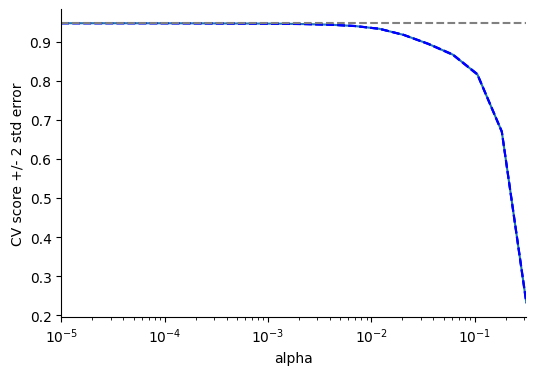

In [158]:
# Plotting scores (e.g., R-squared in this case) and alphas (e.g., the regularization parameter)
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.semilogx(alphas,scores)
ax.semilogx(alphas,scores + std_error, 'b--')
ax.semilogx(alphas,scores - std_error, 'b--')
ax.fill_between(alphas,scores + std_error, scores - std_error, alpha=0.2)
ax.set_ylabel('CV score +/- 2 std error')
ax.set_xlabel('alpha')
ax.axhline(np.max(scores), linestyle='--', color='.5')
ax.set_xlim([alphas[0], alphas[-1]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

# **Decision tree**

Best Parameters:  {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Score:  0.9872697722910925


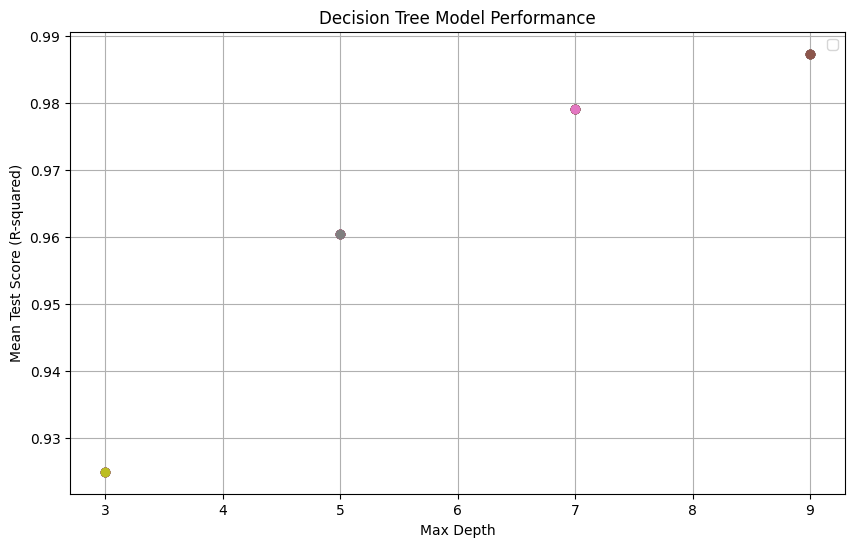

In [159]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Define the decision tree regressor
dt = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=folds, scoring='r2', n_jobs=CPUS-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Get the mean test scores and standard deviations
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

# Plotting mean test scores against hyperparameters
plt.figure(figsize=(10, 6))
for mean_score, std_score, param in zip(mean_scores, std_scores, params):
    plt.errorbar(param['max_depth'], mean_score, yerr=std_score, fmt='o')

plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score (R-squared)')
plt.title('Decision Tree Model Performance')
plt.legend()
plt.grid(True)
plt.show()


# **Random Forest**

The computational demands of algorithms like random forests and gradient boosting are considerable due to their complexity and the large number of decision trees involved. Each run of these algorithms can take a substantial amount of time, especially when performing precise grid searches to find optimal hyperparameters. A grid search involves trying out different combinations of hyperparameters to find the best configuration, which can be computationally expensive, potentially taking over an hour to complete.

To mitigate these long runtimes, we made adjustments to our approach. Firstly, we narrowed down the search range for hyperparameters, focusing on values that are more likely to yield good results based on prior knowledge or experimentation. By reducing the range of values to explore, we can limit the number of combinations tested during the grid search, thereby reducing the overall computational burden.

Additionally, we reduced the number of folds in cross-validation to 2. Cross-validation is a technique used to assess the performance of a model and tune hyperparameters by splitting the data into multiple subsets, or folds. Each fold is used as a validation set while the rest of the data is used for training. By decreasing the number of folds from, for example, 3 to just 2, we can speed up the process since there are fewer iterations required. However, it's important to note that this reduction in fold number may slightly decrease the reliability of the model evaluation, as there is less variability in the validation process.

Overall, these adjustments were made to strike a balance between computational efficiency and model performance. By focusing the search on promising hyperparameter ranges and reducing the complexity of cross-validation, we were able to significantly decrease the runtime of the algorithms while still maintaining a reasonable level of model accuracy.

In [160]:
## Import various ML classes from Scikit-learn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

In [161]:
rf = RandomForestRegressor(random_state=SEED)

In [162]:
rf_cv = cross_val_score(rf,
                        X_train,
                        y_train,
                        cv=folds,
                        scoring='r2',
                        n_jobs=CPUS-1
                       )
print(f"Default parameters:\n{rf.get_params()}")
print(f"Fold scores:\n{rf_cv}")
print(f"Mean score: {rf_cv.mean():.8f}")

Default parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 24, 'verbose': 0, 'warm_start': False}
Fold scores:
[0.99251252 0.99261738 0.9926412 ]
Mean score: 0.99259036


In [163]:
pgrid = {
    'n_estimators': [261,472,577],
    'max_features': ['sqrt','log2'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2,4],
}

@timer_func
def random_forest_rs(pgrid,folds):
    rf_rs = RandomizedSearchCV(estimator=rf,
                               param_distributions=pgrid,
                               scoring='r2',
                               n_iter=30,
                               cv=2,
                               verbose=10,
                               n_jobs=CPUS-1,
                               random_state=SEED,
                               error_score='raise'  # Add this line
                              ).fit(X_train,y_train)

    return rf_rs

rf_rs = random_forest_rs(pgrid,folds)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV 1/2; 1/24] START max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=261
[CV 1/2; 1/24] END max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=261;, score=0.992 total time=  14.0s
[CV 2/2; 1/24] START max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=261
[CV 2/2; 1/24] END max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=261;, score=0.991 total time=  21.1s
[CV 1/2; 2/24] START max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=472
[CV 1/2; 2/24] END max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=472;, score=0.992 total time=  25.4s
[CV 2/2; 2/24] START max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=472
[CV 2/2; 2/24] END max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=472;, score=0.992 total time=  25.0s
[CV 1/2; 3/24] START max_featur

In [164]:
print(f"Best parameters:\n{rf_rs.best_params_}")
print(f"Best score:\n{rf_rs.best_score_}")

Best parameters:
{'n_estimators': 472, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best score:
0.9915445218647763


In [165]:
# Instantiate model with optimal parameters
cval(RandomForestRegressor(random_state=SEED, **rf_rs.best_params_),X_train,y_train)

Fold scores:
[0.99206521 0.99199254 0.9918861 ]
Mean score: 0.99198128
Default parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 472, 'n_jobs': None, 'oob_score': False, 'random_state': 24, 'verbose': 0, 'warm_start': False}
Function 'cval' executed in 0:01:33.223381


array([0.99206521, 0.99199254, 0.9918861 ])

# **Gradient Boosting**

In [166]:
gb = GradientBoostingRegressor(random_state=SEED)

In [167]:
# gb_cv = cval(gb,X_train,y_train)
gb_cv = cross_val_score(gb,
                        X_train,
                        y_train,
                        cv=folds,
                        scoring='r2',
                        n_jobs=CPUS-1
                       )
print(f"Default parameters:\n{gb.get_params()}")
print(f"Fold scores:\n{gb_cv}")
print(f"Mean score: {gb_cv.mean():.8f}")

Default parameters:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 24, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Fold scores:
[0.99165226 0.99169881 0.99167165]
Mean score: 0.99167424


In [168]:
pgrid = {
    'learning_rate': [0.1,0.05],
    'n_estimators': [100,300],
    'max_depth': [4,6],
    'min_samples_leaf': [1,5]
}

In [169]:
@timer_func
def gradient_boosting_gs(pgrid, folds):
    gb_gs = RandomizedSearchCV(estimator=gb,
                               param_distributions=pgrid,
                               scoring='r2',
                               n_iter=30,
                               cv=2,
                               verbose=10,
                               n_jobs=CPUS-1,
                               random_state=SEED
                              ).fit(X_train,y_train)

    return gb_gs

gb_gs = gradient_boosting_gs(pgrid,folds)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2; 1/16] START learning_rate=0.1, max_depth=4, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 16 is smaller than n_iter=30. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/2; 1/16] END learning_rate=0.1, max_depth=4, min_samples_leaf=1, n_estimators=100;, score=0.993 total time=   3.8s
[CV 2/2; 1/16] START learning_rate=0.1, max_depth=4, min_samples_leaf=1, n_estimators=100
[CV 2/2; 1/16] END learning_rate=0.1, max_depth=4, min_samples_leaf=1, n_estimators=100;, score=0.993 total time=   3.8s
[CV 1/2; 2/16] START learning_rate=0.1, max_depth=4, min_samples_leaf=1, n_estimators=300
[CV 1/2; 2/16] END learning_rate=0.1, max_depth=4, min_samples_leaf=1, n_estimators=300;, score=0.993 total time=  14.4s
[CV 2/2; 2/16] START learning_rate=0.1, max_depth=4, min_samples_leaf=1, n_estimators=300
[CV 2/2; 2/16] END learning_rate=0.1, max_depth=4, min_samples_leaf=1, n_estimators=300;, score=0.993 total time=  11.9s
[CV 1/2; 3/16] START learning_rate=0.1, max_depth=4, min_samples_leaf=5, n_estimators=100
[CV 1/2; 3/16] END learning_rate=0.1, max_depth=4, min_samples_leaf=5, n_estimators=100;, score=0.993 total time=   4.6s
[CV 2/2; 3/16] START learning_rate=

In [170]:
print(f"Best parameters:\n{gb_gs.best_params_}")
print(f"Best score:\n{gb_gs.best_score_}")

Best parameters:
{'n_estimators': 300, 'min_samples_leaf': 5, 'max_depth': 6, 'learning_rate': 0.1}
Best score:
0.993495163464571


In [171]:
cval(GradientBoostingRegressor(random_state=SEED, **gb_gs.best_params_),X_train,y_train)

Fold scores:
[0.99350236 0.99353756 0.99361579]
Mean score: 0.99355190
Default parameters:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_iter_no_change': None, 'random_state': 24, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Function 'cval' executed in 0:01:06.810598


array([0.99350236, 0.99353756, 0.99361579])

In [172]:
print(f"OLS: {r_cv.mean():.6f}")
print(f"Lasso: {lr_gs.best_score_:.6f}")
print(f"Random Forest: {rf_rs.best_score_:.6f}")
print(f"Gradient Boosting: {gb_gs.best_score_:.6f}")

OLS: 0.943615
Lasso: 0.943615
Random Forest: 0.991545
Gradient Boosting: 0.993495


# **Question 7**

In [185]:
from sklearn.metrics import mean_squared_error, r2_score

yvar = 'l_price'
y_test = df_test[yvar]

# exclude zip to make things run more quickly
xvars =  (
    ['clarity_encoded','cut_encoded','color_encoded','l_carat']
    + [c for c in df_test.columns if c.startswith('i_c_shape') ]
)
X_test = df_test[xvars]

# Use the best model obtained from grid search to predict on the test set
best_dt_model = grid_search.best_estimator_
y_pred_test = gb_gs.predict(X_test)

# Calculate and print the model scores on train and test data
train_score = gb_gs.score(X_train, y_train)
test_score = gb_gs.score(X_test, y_test)

print(f"Train data score: {train_score:.6f}")
print(f"Test data score: {test_score:.6f}")

Train data score: 0.994092
Test data score: 0.993607


The performance of our trained model is exceptionally high, with a train data score of 0.994092 and a test data score of 0.993607. These scores indicate that the model can effectively capture and generalize patterns in the data, showcasing its robustness and predictive capability.

# **Question 8**

In [189]:
from sklearn.metrics import mean_squared_error, r2_score

yvar = 'l_price'
y_total = df[yvar]

# exclude zip to make things run more quickly
xvars =  (
    ['clarity_encoded','cut_encoded','color_encoded','l_carat']
    + [c for c in df.columns if c.startswith('i_c_shape') ]
)
X_total = df[xvars]

# Use the best model obtained from grid search to predict on the test set
best_dt_model = grid_search.best_estimator_
y_pred = best_dt_model.predict(X_total)

# Calculate and print the model scores on train and test data
total_score = best_dt_model.score(X_total, y_total)

print(f"Total data score: {total_score:.6f}")


Total data score: 0.987941


# **Error analysis**

In [190]:
y_pred

array([ 5.56696998,  5.56696998,  5.56696998, ..., 12.78808642,
       12.78808642, 12.78808642])

In [191]:
df['error'] = np.log(df.price) - y_pred
df['error']

error
Loading... (need help?)


Text(0.5, 1.0, 'Error analysis')

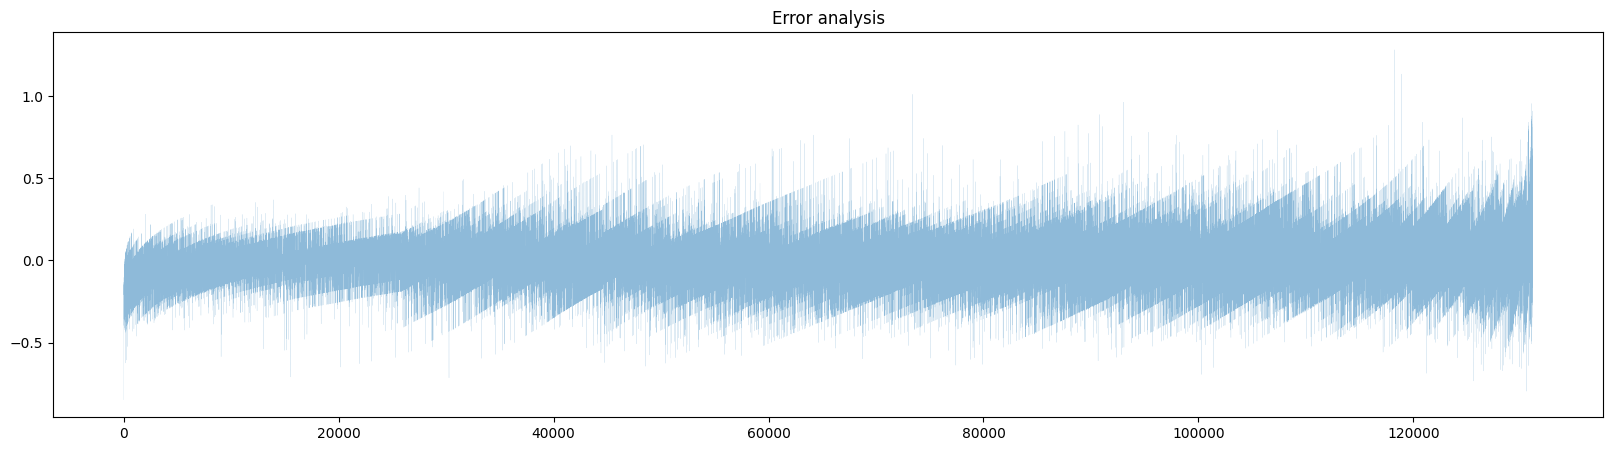

In [192]:
plt.figure(figsize = (20,5))
plt.plot(df['error'],linewidth = 0.1,alpha = 0.5)
plt.title("Error analysis")

# **Why might Kerry find this information useful?**
The data fields for diamonds you've provided are significant for several reasons when using machine learning algorithms, such as decision trees, to predict diamond prices:

1. **Feature Variety**: The fields cover a range of factors that affect diamond prices, from physical attributes like shape, cut, color, and clarity, to economic factors like carat weight and the date of delivery. This variety enables a model to consider different aspects that influence pricing.

2. **Industry Standards**: The color and clarity grades are based on Gemological Institute of America (GIA) standards, which are internationally recognized benchmarks. This standardization allows for consistent training of the model and likely improves its accuracy and reliability.

3. **Quantitative and Qualitative Data**: The dataset includes both categorical (qualitative) and continuous (quantitative) data. Machine learning algorithms can exploit this variety to find complex patterns and relationships between different features and the price.

4. **Price Prediction**: Price is a critical target variable. Having the price associated with each diamond's features allows the algorithms to train on real-world data and predict prices for new, unseen diamonds based on learned patterns.

5. **Economic Implications**: Accurately predicting diamond prices can have substantial economic implications for businesses and consumers, helping in inventory valuation, investment decisions, and purchasing considerations.

6. **Market Analysis**: Over time, the data can be used to analyze market trends, understand consumer preferences, and adapt to changing market conditions, which is invaluable for diamond retailers and manufacturers.

7. **Customization**: Decision trees and other algorithms can be tailored to individual preferences or market segments by weighting certain features more heavily, like prioritizing carat over color or vice versa, depending on the target customers.